In [80]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import healpy as hp
import matplotlib.pyplot as plt
from IPython.display import clear_output
# paralelizacion
from multiprocessing import Pool
from functools import partial
import platform
import psutil
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import norm
from scipy.optimize import minimize
from importlib import reload


rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 400
rcParams["font.size"] = 18


# Important parameters

#### **pts** is related to the number of points in the grid or resolution of the grid (don't change it)

#### **q0f** & **h0f** are fiducial values for LCDM

#### **repetitions** is the number of times hem_comp will be run (for testinf purposesm try for 5 repetitions)

In [81]:
pts = hp.nside2npix(4) # Resolution for Nside = 16
h0f = 0.678 # fiducial value of h0 for planck
q0f = -0.574
#h0f = 0.7304 # fiducial value of h0 for pantheon+
zup= 0.1# upper limit of the redshift range
zdown= 0.0 # lower limit of the redshift range0
prefix_name = '[SH0ES_CALIB][HEALPIX]' # This is for file naming purposes 

In [343]:
loc_lcparam = 'datos/Pantheon+SH0ES.dat.txt'
loc_lcparam_sys = 'datos/Pantheon+SH0ES_STAT+SYS.cov.txt'

In [344]:
lcparam = np.loadtxt(loc_lcparam, skiprows=1, usecols=(2, 8, 9, 10, 11, 26, 27,12, 13))
lcparam_sys = np.loadtxt(loc_lcparam_sys,skiprows= 1)

ind = np.where((lcparam[:, 0] < zup) & (lcparam[:, 0] > zdown))[0]

zz = lcparam[ind, 0] # zhd
mz = lcparam[ind, 1] # mb_corr 
sigmz = lcparam[ind, 2] # m_b_corr_err_DIAG 
muz = lcparam[ind, 3] # MU_SH0ES
sigmuz = lcparam[ind, 4] # MU_SH0ES_ERR_DIAG
ra = lcparam[ind, 5] 
dec = lcparam[ind, 6]
muceph = lcparam[ind, 7]
hostyn = lcparam[ind, 8]

hostyn_ind = np.where(hostyn == 1)[0]
cov_z = lcparam_sys.reshape(1701, 1701)
cov_z = cov_z[:len(zz), :len(zz)]
inv_cov_z = np.linalg.inv(cov_z)

print("We have", len(zz), f"SNe with  {zdown} < z < {zup}")
print("\nCov matrix shape:", cov_z.shape)

cov_mat = pd.DataFrame(cov_z, columns=range(len(zz)))


We have 741 SNe with  0.0 < z < 0.1

Cov matrix shape: (741, 741)


In [85]:
# Cosmology model are defined in the file cosmology.py
from cosmology import mu

### Saving data into r1 array and positions (x,y,z) into v1 array


In [86]:
# Define some global variables

# Data array
r1 = np.column_stack([ra, dec, zz, mz, sigmz, muz, sigmuz, muceph, hostyn]) 

# Each SNe position in cartesian coordinates
v1 = np.column_stack([np.sin(ra)*np.cos(dec), np.sin(ra)*np.sin(dec), np.cos(ra)])



### Loop principal del método Hemispheric Comparison for fixed q0

### Parallelization of the principal loop using iPool from multiprocessing

In [87]:
# The function get_healpix_vectors is defined in healpix_vectors.py and it returns the symmetry axes for each pixel defined by HEALPIX

from healpix_vectors import get_healpix_vectors

nside = 2# Resolution

healpix_dirs = get_healpix_vectors(nside)

In [88]:
import hem_comp_functions


# We obtain the map by running hem_comp_functions.exec_map. This function runs the hemispheric comparison functions for each pixel to form a complete map.

h0u, h0d, q0u, q0d = hem_comp_functions.exec_map(healpix_dirs, v1 , r1, hostyn, cov_mat, h0f, q0f)

100%|██████████| 24/24 [00:00<00:00, 235194.62it/s]


In [89]:
# Store up and down hemisphere position vectors for plotting purposes.

hdiru = np.array(healpix_dirs)
hdird = -np.array(healpix_dirs)

# save the directions into one array with the form [hdiru,hdird]
hdirs = np.concatenate((hdiru, hdird))

h0 = np.concatenate((h0u, h0d))
q0 = np.concatenate((q0u, q0d))

# convert the directions of axes into spherical coordinates
theta = np.arccos(hdirs[:, 2])
phi = np.radians(180) - np.arctan2(hdirs[:, 1], hdirs[:, 0])


In [92]:
# Calculate max anisotroy for each parameter

delta_h0_data_max = np.max(h0) - np.min(h0)
delta_q0_data_max = np.max(q0) - np.min(q0)

print(delta_h0_data_max)
print(delta_q0_data_max) 

0.010418918578733005
1.0415419949805993


Calculate error bars for q0 and h0


In [339]:
from get_statistics import map_statistics
map_statistics(h0, q0, delta_h0_data_max, delta_q0_data_max)

1 sigma h0:  0.729788089551124 +/- 0.002687949309601155
1 sigma q0:  2.7333159833036245 +/- 0.2737488719486452


{'h0_mean': 0.729788089551124,
 'q0_mean': 2.7333159833036245,
 'h0_std_dev': 0.002687949309601155,
 'q0_std_dev': 0.2737488719486452}

### We run hem_comp for the first time to generate the map for the original data

# Making q0 and h0 maps using HEALpy


In [94]:
rcParams['font.size'] = 4

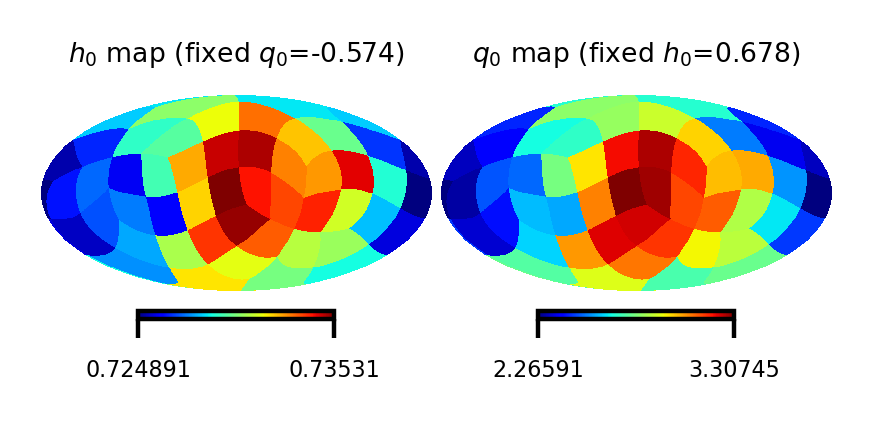

In [95]:
from generate_map import generate_map

# Maps are generated by the function generate_map which is defined in generate_map.py
h0map, q0map = generate_map(nside, theta, phi, h0, q0, h0f, q0f)

# Plot the generated maps side by side
plt.figure(figsize=(2, 1))

hp.mollview(h0map, coord="cg", title=rf'$h_0$ map (fixed $q_0$={q0f})', unit='', notext=True, norm='hist', cmap='jet',
            min=min(h0), max=max(h0), fig=1, sub=(1, 2, 1))
hp.mollview(q0map, coord="cg", title=rf'$q_0$ map (fixed $h_0$={h0f})', unit='', notext=True, norm='hist', cmap='jet',
            min=min(q0), max=max(q0), fig=1, sub=(1, 2, 2))

#plt.savefig(f'figures/{prefix_name}[NO_SM](hf={h0f}_qf={q0f})({zup}>z>{zdown})({npix})map.png')

plt.show()



# Synthetic data implementation


### Uniform supernovae distribution

Below we have generated a random position vector for each supernova according to an uniform distribution. For more details refer to [Synthetic data on a sphere](<(1)synthetic_data.ipynb>).



In [109]:
#now we want to create this len(ra) vectors for each repetition of the simulation and store them in a list
repetitions = 20
v1_iso = np.zeros((repetitions, len(ra), 3)) #We store the new supernova positions (x,y,z) in v1_iso

for i in range(repetitions):
    vecti = np.random.randn(len(ra), 3)  # three random numbers vector (x,y,z)
    vecti /= np.linalg.norm(vecti, axis=1)[:, np.newaxis]  # normalize the vector
    thetai = np.arccos(vecti[:, 2]) # arccos(z)
    phii = np.arctan2(vecti[:, 1], vecti[:, 0]) # arctan(y/x)
    deci = thetai  # declination
    rai = np.pi - phii # right ascension
    v1i = np.column_stack([np.sin(rai)*np.cos(deci), np.sin(rai)*np.sin(deci), np.cos(rai)])
    v1_iso[i] = v1i
v1_iso.shape

# v1_iso is a list of lenght 500 repetitions which contains 741 vectors (x,y,z) for each supernovae position (isotropic synthetic distribution)

(20, 741, 3)

#### Here we are going to run the 500 repetitions for the synthetic uniformly distributed data.

In [110]:
repetitions = 20

In [111]:
h0u_iso = []
h0d_iso = []
q0u_iso = []
q0d_iso = []

i = 1
for v1_it in v1_iso:
    clear_output()
    print('Repetition {}/{}'.format(i, repetitions))
    v1 = v1_it
    # Execute map with the given v1_iso element
    h0u_aux, h0d_aux, q0u_aux, q0d_aux = exec_map(healpix_dirs, v1 , r1, hostyn, cov_mat, h0f, q0f)
    
    h0u_iso.append(np.array(h0u_aux))
    h0d_iso.append(np.array(h0d_aux))
    q0u_iso.append(np.array(q0u_aux))
    q0d_iso.append(np.array(q0d_aux))
    i += 1

# Restore original v1 data
v1 = np.column_stack([np.sin(ra)*np.cos(dec), np.sin(ra)*np.sin(dec), np.cos(ra)])

Repetition 20/20


100%|██████████| 24/24 [00:00<00:00, 198939.32it/s]


In [113]:
# Convert all arrays to numpy arrays
h0u_iso = np.array(h0u_iso)
h0d_iso = np.array(h0d_iso)
q0u_iso = np.array(q0u_iso)
q0d_iso = np.array(q0d_iso)

In [114]:

h0m_iso = np.concatenate((h0u_iso, h0d_iso), axis=1)
q0m_iso = np.concatenate((q0u_iso, q0d_iso), axis=1)

# Find the maximum anisotropy for each repetition and store it
delta_h0_iso_max = np.max(h0m_iso, axis=1) - np.min(h0m_iso, axis=1)
delta_q0_iso_max = np.max(q0m_iso, axis=1) - np.min(q0m_iso, axis=1)


# Datos falsos para probar el codigo!!!!!!!

In [132]:
delta_h0_iso_max = delta_h0_iso_max[0]+ 0.01*np.random.randn(1000)

delta_q0_iso_max = delta_q0_iso_max[0]+ 0.1*np.random.randn(1000)

# Ploting the iterations

We want to adjust a Gaussian to the data and include lines which represent the original data maximum anisotropy and some fixed percentiles in the same plot as the histogram.

First, we fit a gaussian to the data. We do it using the function fit_gaussian in fit_gaussian.py

In [ ]:

from fit_gaussian import fit_gaussian

# We need to import the fit_gaussian function from fit_gaussian.py. This function is in charge or generating the gaussian for our data. 


# Fit a gaussian to the data using the fit_gaussian function. This function returns the x and y values of the gaussian.
x_gauss_h0_iso, y_gauss_h0_iso = fit_gaussian(delta_h0_iso_max)
x_gauss_q0_iso, y_gauss_q0_iso = fit_gaussian(delta_q0_iso_max)

# Find the selected percentiles in the synthetic data max anisotropy
percentile_5_h0_iso = np.percentile(delta_h0_iso_max, 5)
percentile_95_h0_iso = np.percentile(delta_h0_iso_max, 95)
percentile_5_q0_iso = np.percentile(delta_q0_iso_max, 5)
percentile_95_q0_iso = np.percentile(delta_q0_iso_max, 95)



### Plotting the data

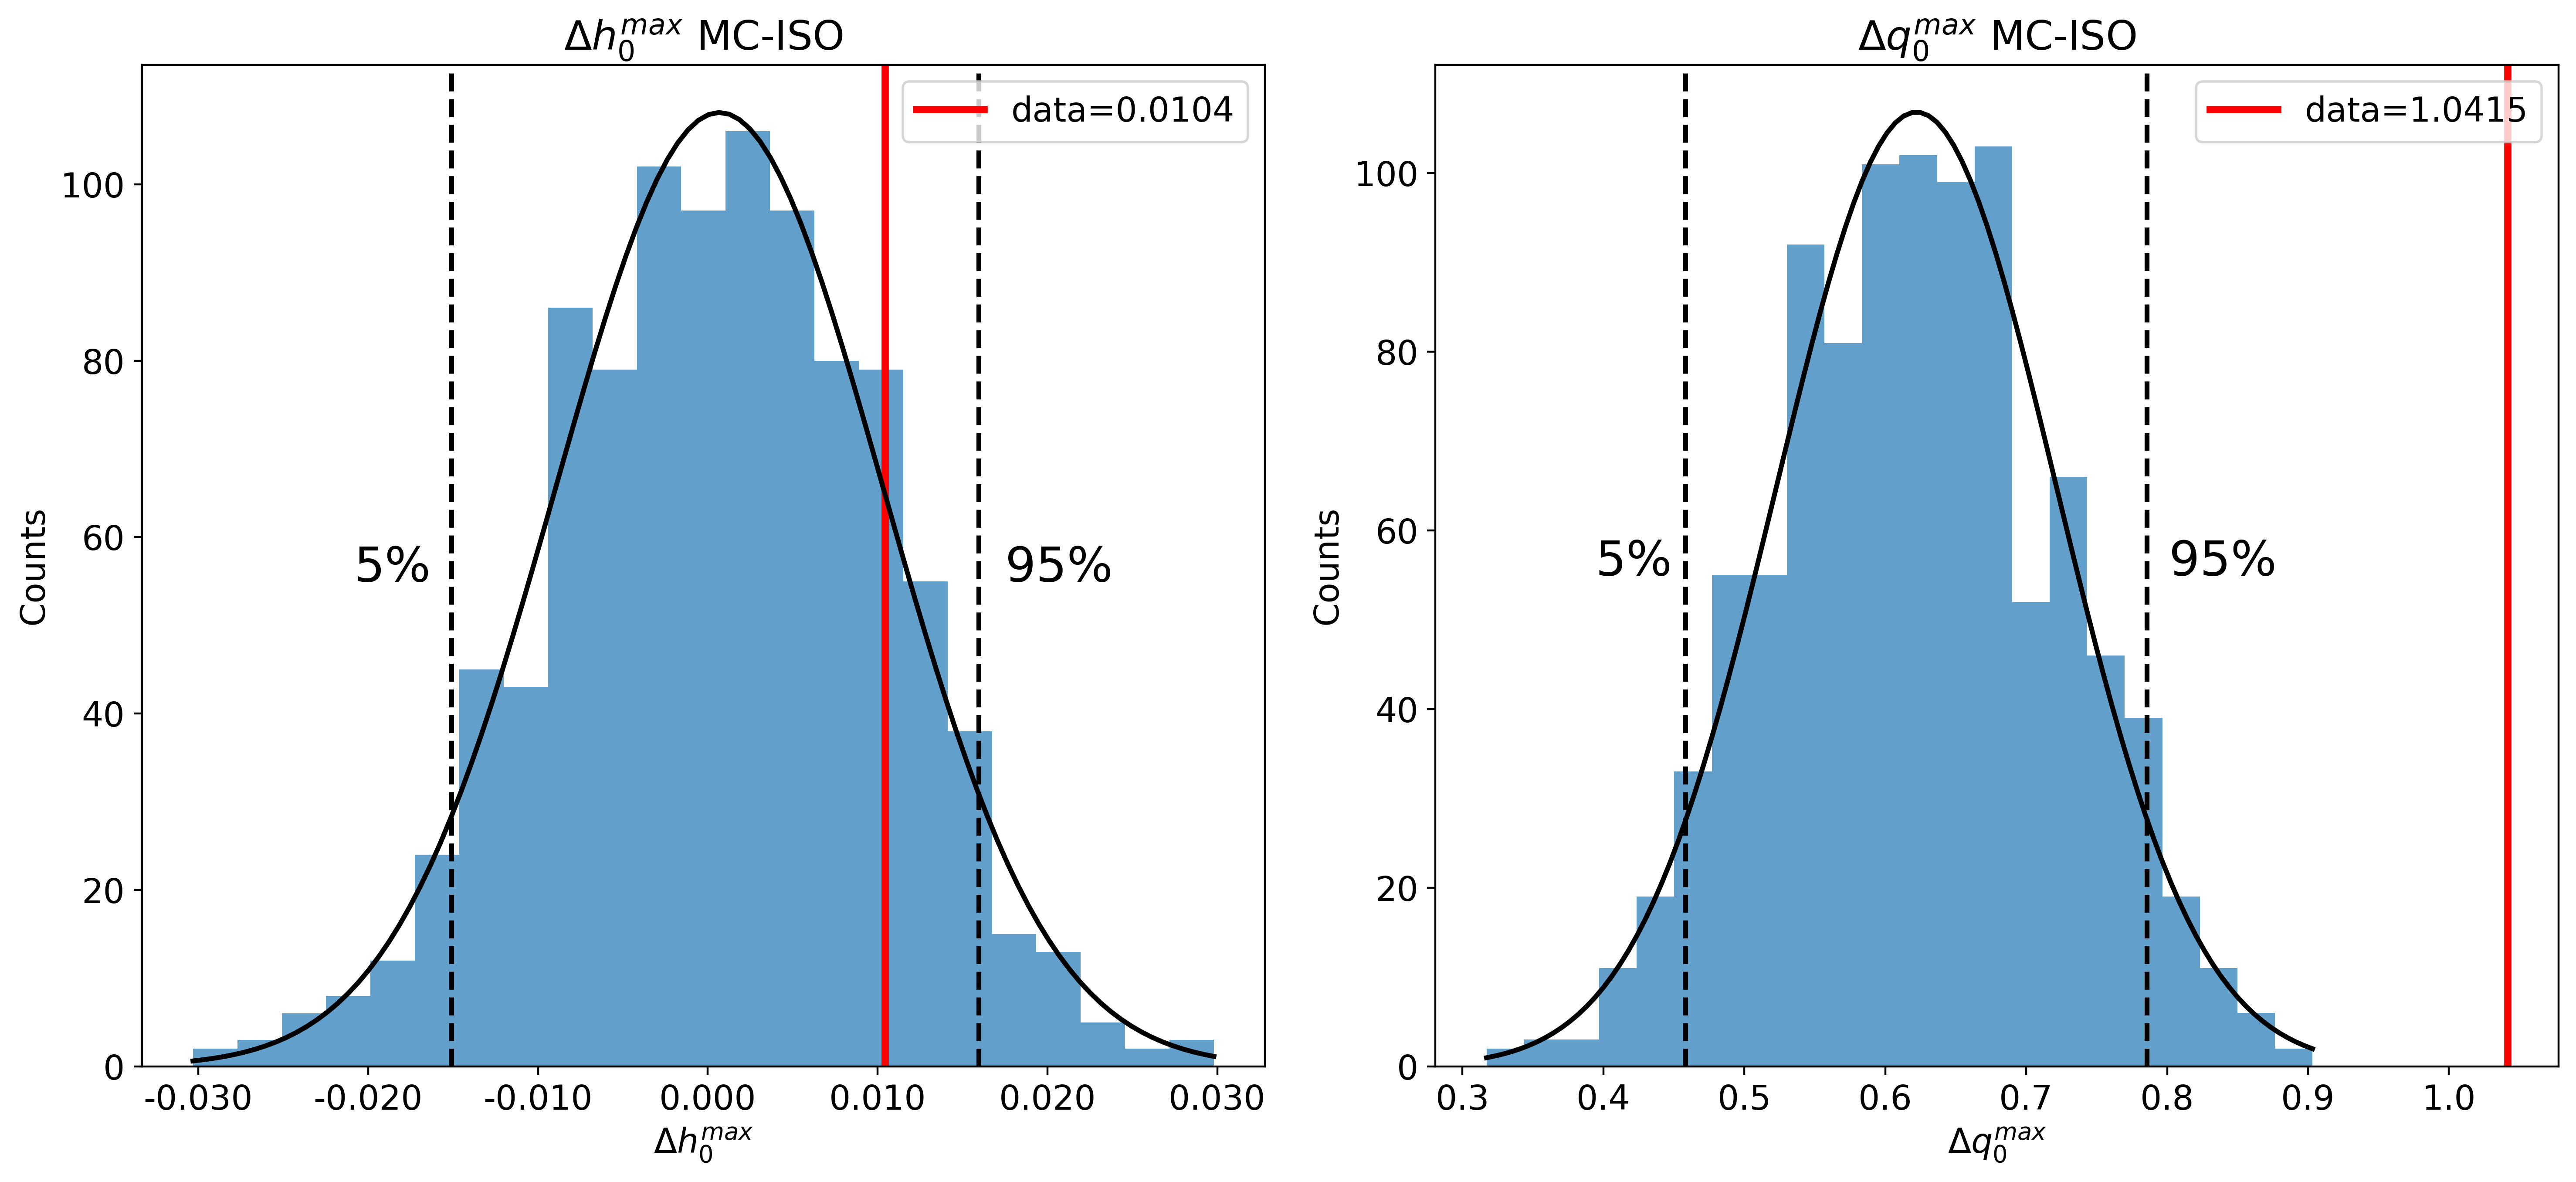

In [148]:
import matplotlib.ticker as ticker
rcParams['font.size'] = 14

# Create the histograms using subplots
hist4, ax4 = plt.subplots(1, 2, figsize=(15, 7))

# Histogram for delta_h0_iso_max
counts_h0_iso, bins_h0_iso, _ = ax4[0].hist(
    delta_h0_iso_max, bins='auto', density=False, alpha=0.7)

# Set the bin width to the difference between the first and second bin
bin_width_h0_iso = bins_h0_iso[1] - bins_h0_iso[0]

# Red line for data max anisotropy
ax4[0].axvline(delta_h0_data_max, color='red', linestyle='solid',
               linewidth=3, label='data=%0.4f' % delta_h0_data_max)

# Dashed lines  for 5% and 95% percentiles
ax4[0].axvline(percentile_5_h0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[0].axvline(percentile_95_h0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[0].text(percentile_5_h0_iso - 2.2*bin_width_h0_iso, 55, '5%', fontsize=20)

ax4[0].text(percentile_95_h0_iso+0.6*bin_width_h0_iso, 55, '95%', fontsize=20)

# Plot the Gaussian
ax4[0].plot(x_gauss_h0_iso, y_gauss_h0_iso * len(delta_h0_iso_max) * bin_width_h0_iso,
            'black', linewidth=2)  # Scale Gaussian fit to match total counts

# Format x axis ticks with 3 decimals
ax4[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Naming labels and titles
ax4[0].set_xlabel(r'$Δh_0^{max}$')
ax4[0].set_ylabel('Counts')
ax4[0].legend(loc='upper right')
ax4[0].set_title(r'$Δh_0^{max}$ MC-ISO')

##########################################################################################################


# Histogram for delta_q0_iso_max
counts_q0_iso, bins_q0_iso, _ = ax4[1].hist(
    delta_q0_iso_max, bins='auto', density=False, alpha=0.7)

bin_width_q0_iso = bins_q0_iso[1] - bins_q0_iso[0]

# Red line for data max anisotropy
ax4[1].axvline(delta_q0_data_max, color='red', linestyle='solid',
               linewidth=3, label='data=%0.4f' % delta_q0_data_max)

# Dashed lines  for 5% and 95% percentiles
ax4[1].axvline(percentile_5_q0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[1].axvline(percentile_95_q0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[1].text(percentile_5_q0_iso - 2.4*bin_width_q0_iso, 55, '5%', fontsize=20)

ax4[1].text(percentile_95_q0_iso + 0.6 *
            bin_width_q0_iso, 55, '95%', fontsize=20)


# Plot the Gaussian
ax4[1].plot(x_gauss_q0_iso, y_gauss_q0_iso * len(delta_q0_iso_max) * bin_width_q0_iso,
            'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax4[1].set_xlabel(r'$Δq_0^{max}$')
ax4[1].set_ylabel('Counts')
ax4[1].legend(loc='upper right')
ax4[1].set_title(r'$Δq_0^{max}$ MC-ISO')
plt.tight_layout()
#plt.savefig(f'histograms/{prefix_name}[ISO](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png')
plt.show()


## Synthetic distance modulus (sampled from a normal distribution)

### We are going to create a normal distribution with mean $\mu_{fid}$ and $\sigma$ will be the original error on the distance modulus.

For more details on synthetic data, refer to [Synthethic data for distance modulus](synthetic_data.ipynb).



In [269]:
repetitions = 10

mu_fid = np.array([mu(z, h0f, q0f) for z in zz]) # 1D array 741 
r1_lcdm = np.tile(r1, (repetitions, 1, 1)) # 3D array (repetitions, 741, 7) this is the grid of repetitions of r1 which will be modified to include the new mu_sample values.

for i in range(repetitions):
    mu_sample = np.random.normal(mu_fid, sigmuz)
    r1_lcdm[i,:,5] = mu_sample


For each repetition we sample a new distance modulus for each supernovae from the normal distribution  $N(\mu_{fid}, sigmuz)$ 

Where sigmuz is the original error on the distance modulus and $\mu_{fid}$ is the fiducial value for the distance modulus.

#### we call the function using he map method from pool object as follows:

In [ ]:
import hem_comp_functions
reload(hem_comp_functions)

h0um_lcdm = []
h0dm_lcdm = []
q0um_lcdm = []
q0dm_lcdm = []

i = 1
for r1_it in r1_lcdm:
    clear_output()
    print('Repetition {}/{}'.format(i, repetitions))
    r1 = r1_it
    h0u_aux, h0d_aux, q0u_aux, q0d_aux = hem_comp_functions.exec_map(healpix_dirs, v1 , r1, hostyn, cov_mat, h0f, q0f)
    
    h0um_lcdm.append(np.array(h0u_aux))
    h0dm_lcdm.append(np.array(h0d_aux))
    q0um_lcdm.append(np.array(q0u_aux))
    q0dm_lcdm.append(np.array(q0d_aux))
    i += 1

# Restore original r1 data

r1 = np.column_stack([ra, dec, zz, mz, sigmz, muz, sigmuz, muceph, hostyn]) 

In [311]:
h0um_lcdm = np.array(h0um_lcdm)
h0dm_lcdm = np.array(h0dm_lcdm)
q0um_lcdm = np.array(q0um_lcdm)
q0dm_lcdm = np.array(q0dm_lcdm)

In [312]:
#hdirum_lcdm = np.array(healpix_dirsm_lcdm)
#hdirdm_lcdm = -np.array(healpix_dirsm_lcdm)

#hdirm_lcdm = np.concatenate((hdirum_lcdm, hdirdm_lcdm), axis=1)

h0m_lcdm = np.concatenate((h0um_lcdm, h0dm_lcdm),axis=1)
q0m_lcdm = np.concatenate((q0um_lcdm, q0dm_lcdm),axis=1)

#theta_dirsm_lcdm = np.arccos(hdirm_lcdm[:, :, 2])
#phi_dirsm_lcdm= np.arctan2(hdirm_lcdm[:, :, 1], hdirm_lcdm[:, :, 0])

delta_h0_lcdm_max = np.max(h0m_lcdm, axis=1) - np.min(h0m_lcdm, axis=1)
delta_q0_lcdm_max = np.max(q0m_lcdm, axis=1) - np.min(q0m_lcdm, axis=1)



In [318]:

from fit_gaussian import fit_gaussian

# We need to import the fit_gaussian function from fit_gaussian.py. This function is in charge or generating the gaussian for our data. 


# Fit a gaussian to the data using the fit_gaussian function. This function returns the x and y values of the gaussian.
x_gauss_h0_lcdm, y_gauss_h0_lcdm = fit_gaussian(delta_h0_lcdm_max)
x_gauss_q0_lcdm, y_gauss_q0_lcdm = fit_gaussian(delta_q0_lcdm_max)

# Find the selected percentiles in the synthetic data max anisotropy
percentile_5_h0_lcdm = np.percentile(delta_h0_lcdm_max, 5)
percentile_95_h0_lcdm = np.percentile(delta_h0_lcdm_max, 95)
percentile_5_q0_lcdm = np.percentile(delta_q0_lcdm_max, 5)
percentile_95_q0_lcdm = np.percentile(delta_q0_lcdm_max, 95)

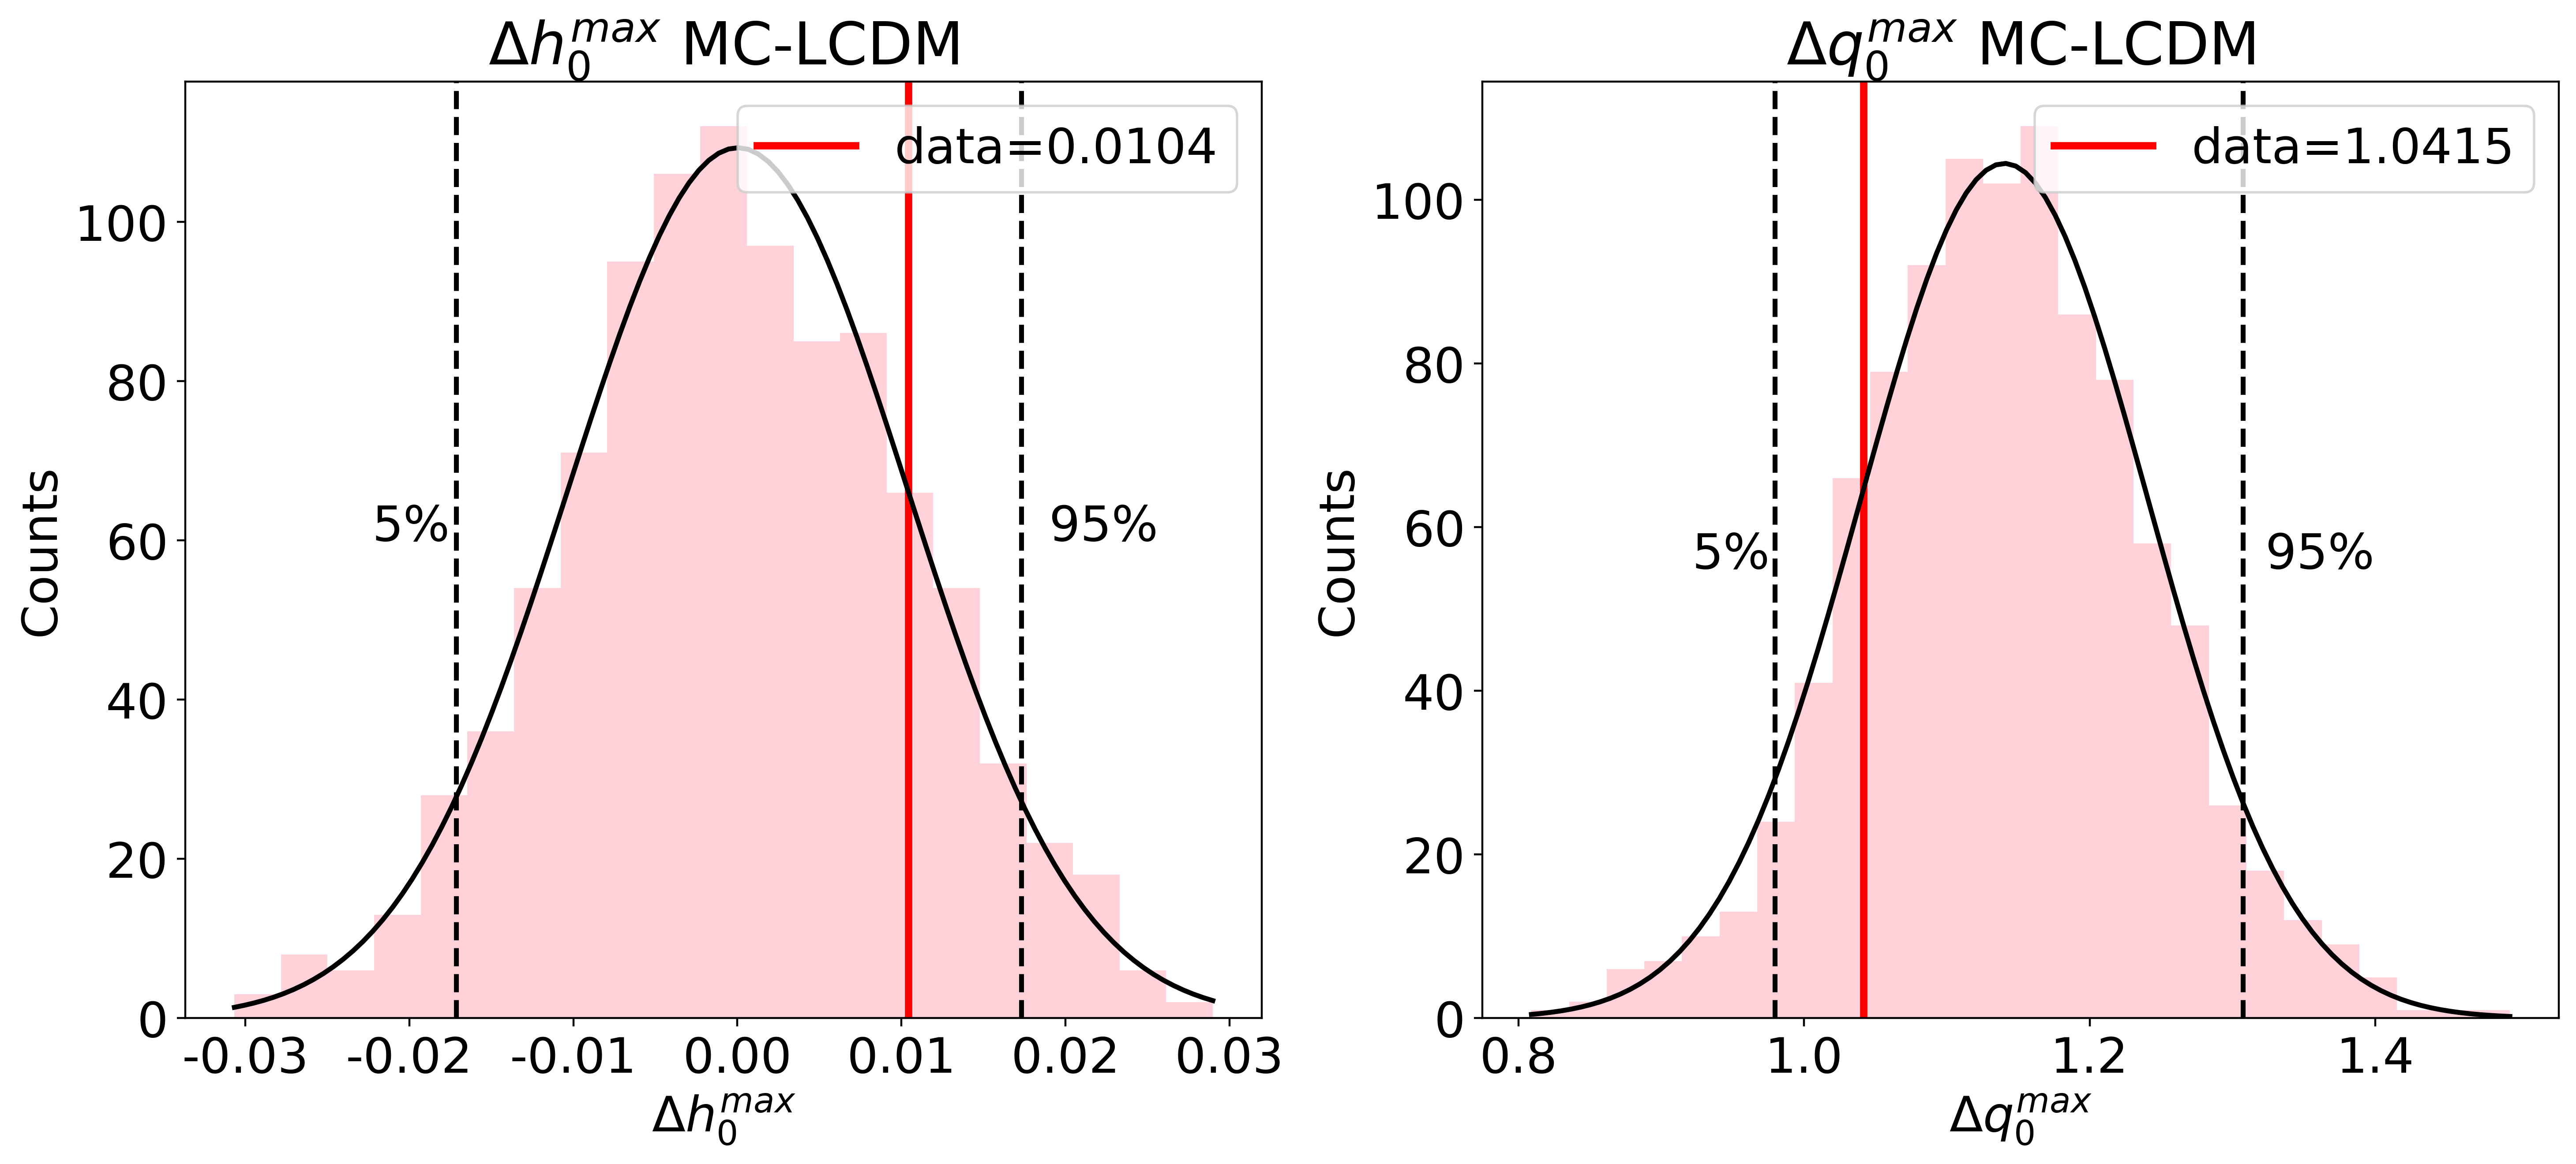

In [332]:
import matplotlib.ticker as ticker

# Create the histograms with subplots
hist3, ax3 = plt.subplots(1, 2, figsize=(15, 7))

# Histogram for delta_h0_lcdm_lcdm_max
counts_h0_lcdm, bins_h0_lcdm, _ = ax3[0].hist(delta_h0_lcdm_max, bins='auto', color='pink', density=False, alpha=0.7)

bin_width_h0_lcdm = bins_h0_lcdm[1] - bins_h0_lcdm[0]

ax3[0].axvline(delta_h0_data_max, color='red', linestyle='solid', linewidth=3, label='data=%0.4f' % delta_h0_data_max)

ax3[0].plot(x_gauss_h0_lcdm, y_gauss_h0_lcdm * len(delta_h0_lcdm_max) * bin_width_h0_lcdm, 'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax3[0].axvline(percentile_5_h0_lcdm, color='black', linewidth=2, linestyle='dashed')
ax3[0].axvline(percentile_95_h0_lcdm, color='black', linewidth=2, linestyle='dashed')

ax3[0].text(percentile_5_h0_lcdm-1.8*bin_width_h0_lcdm, 60, '5%', fontsize=20)
ax3[0].text(percentile_95_h0_lcdm+0.6*bin_width_h0_lcdm, 60, '95%', fontsize=20)

ax3[0].set_xlabel(r'$\Delta h_0^{max}$')
ax3[0].set_ylabel('Counts')
ax3[0].legend(loc='upper right')
ax3[0].set_title(r'$\Delta h_0^{max}$ MC-LCDM')

# Limit the number of decimals on the x-axis labels to 3
ax3[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Histogram for delta_q0_lcdm_lcdm_max
counts_q0_lcdm, bins_q0_lcdm, _ = ax3[1].hist(delta_q0_lcdm_max, bins='auto', color='pink', density=False, alpha=0.7)

bin_width_q0_lcdm = bins_q0_lcdm[1] - bins_q0_lcdm[0]

ax3[1].axvline(delta_q0_data_max, color='red', linestyle='solid', linewidth=3, label='data=%0.4f' % delta_q0_data_max)

ax3[1].plot(x_gauss_q0_lcdm, y_gauss_q0_lcdm * len(delta_q0_lcdm_max) * bin_width_q0_lcdm, 'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax3[1].axvline(percentile_5_q0_lcdm, color='black', linewidth=2, linestyle='dashed')
ax3[1].axvline(percentile_95_q0_lcdm, color='black', linewidth=2, linestyle='dashed')

ax3[1].text(percentile_5_q0_lcdm-2.2*bin_width_q0_lcdm, 55, '5%', fontsize=20)
ax3[1].text(percentile_95_q0_lcdm+0.6*bin_width_q0_lcdm, 55, '95%', fontsize=20)

ax3[1].set_xlabel(r'$\Delta q_0^{max}$')
ax3[1].set_ylabel('Counts')
ax3[1].legend(loc='upper right')
ax3[1].set_title(r'$\Delta q_0^{max}$ MC-LCDM')

plt.tight_layout()
#plt.savefig(f'histograms/{prefix_name}[LCDM](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png')
plt.show()

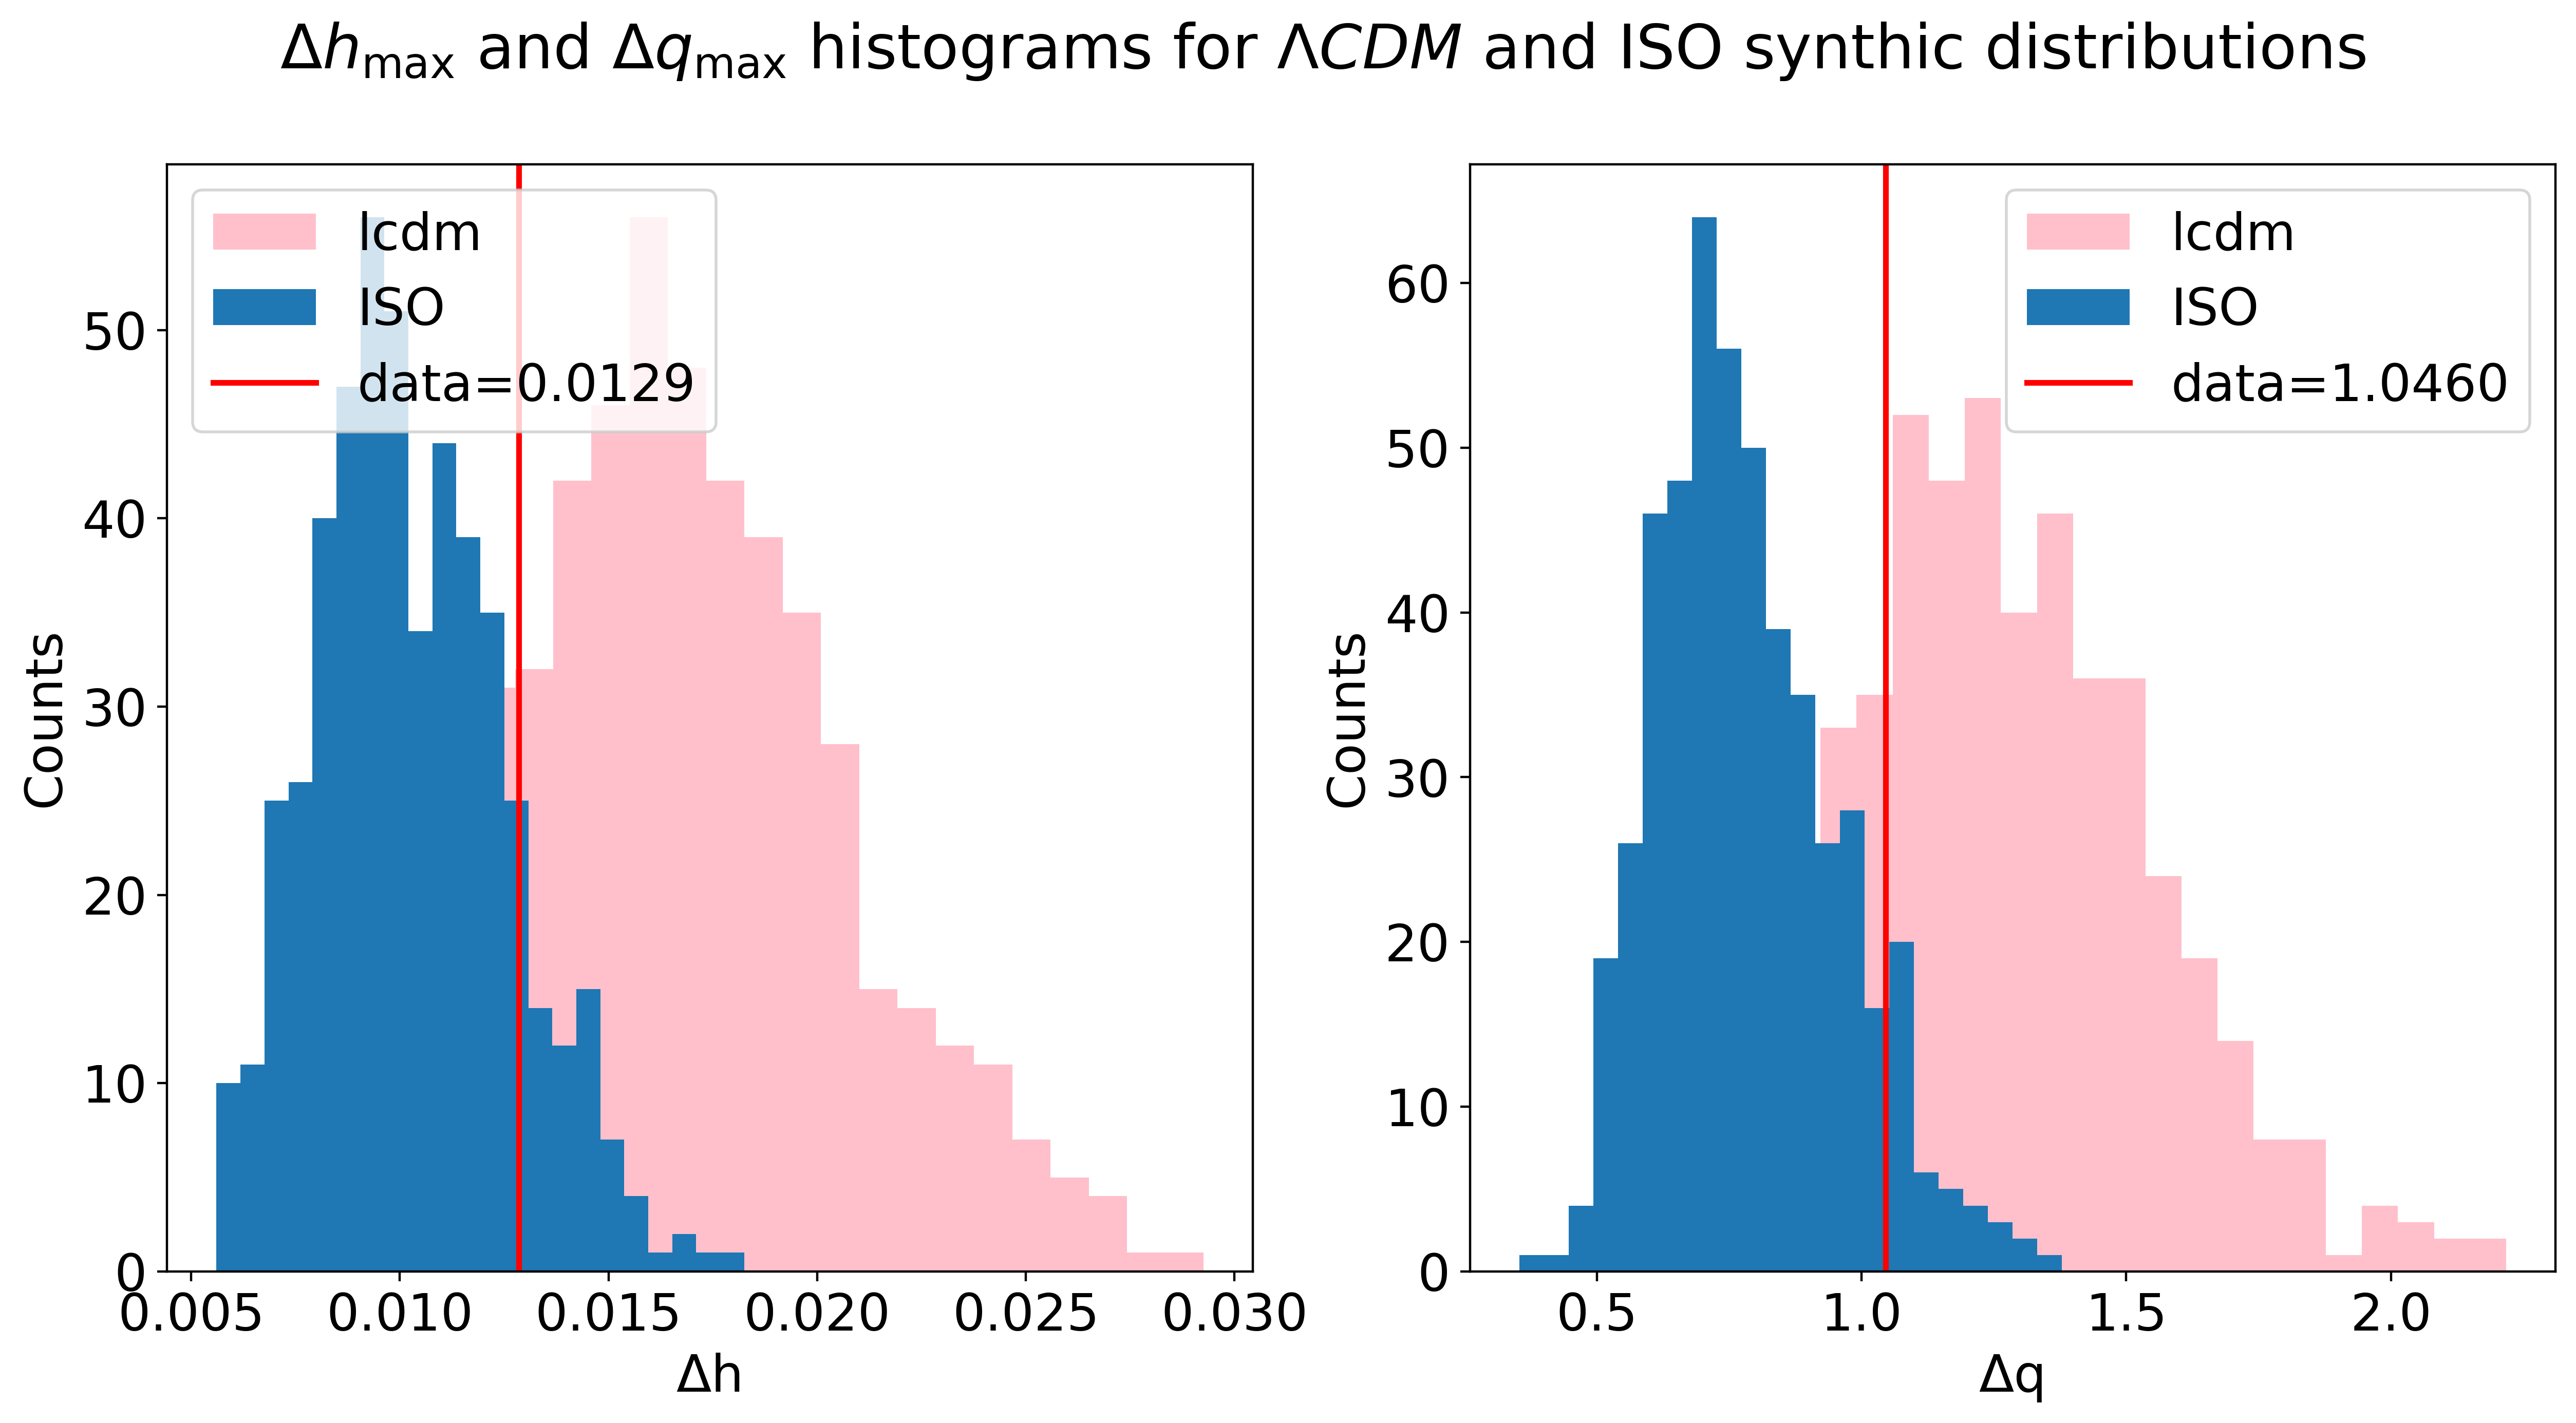

In [39]:
hist2, ax2 = plt.subplots(1, 2, figsize=(15, 7))
ax2[0].hist(delta_h0_lcdm_max,color='pink', bins=22, label='lcdm')
ax2[0].hist(delta_h0_iso_max, bins=22,label='ISO')
#ax2[0].axvline(np.mean(delta_h0_lcdm_max), color='y', linewidth=2,
#               label='mean=%0.3f' % np.mean(delta_h0_lcdm_max))
ax2[0].axvline(delta_h0_data_max, color='r', linewidth=2,
               label='data=%0.4f' % delta_h0_data_max)
ax2[0].legend(loc='upper left')
ax2[0].set_xlabel('Δh')
ax2[0].set_ylabel('Counts')

ax2[1].hist(delta_q0_lcdm_max, bins=22, color='pink', label='lcdm')
ax2[1].hist(delta_q0_iso_max, bins=22, label='ISO')
#ax2[1].axvline(np.mean(delta_q0_lcdm_max), color='y', linewidth=2,
#               label='mean=%0.4f' % np.mean(delta_q0_lcdm_max))
ax2[1].axvline(delta_q0_data_max, color='r', linewidth=2,
               label='data=%0.4f' % delta_q0_data_max)  # plot the data value
ax2[1].legend(loc='upper right')
ax2[1].set_xlabel('Δq')
ax2[1].set_ylabel('Counts')
hist2.suptitle(rf'$Δh_{{\mathrm{{max}}}}$ and $Δq_{{\mathrm{{max}}}}$ histograms for $\Lambda CDM$ and ISO synthic distributions')
#plt.savefig(f'histograms/{prefix_name}[BOTH]({pts}_pts)_({repetitions})_rep_histogram(hf={h0f}_qf={q0f})_({zup}>z>{zdown}).png')
plt.show()

# Saving the results in text files


### Save ISO 

In [78]:
header_iso = f'This is the data for ISO distribution with new set of data for each repetition\n{repetitions} repetitions, {pts} points q0f= {q0f} h0f= {h0f}\n\ndelta_h0_iso_max           delta_q0_iso_max'
filename_iso = f'compilations/{prefix_name}[ISO]({h0f}=h0f_{q0f}=q0f)({repetitions}_rep)({pts}_pts)({zup}>z>{zdown}).txt'
save_data_iso = np.column_stack([delta_h0_iso_max, delta_q0_iso_max])
np.savetxt(filename_iso,save_data_iso, header=header_iso)

### Save LCDM

In [ ]:
header_lcdm = f'[SH0ES_CALIB]This is the data for ISO distribution with new set of data for each repetition\n{repetitions} repetitions, {pts} points q0f= {q0f} h0f= {h0f}\n\ndelta_h0_lcdm_max            delta_q0_lcdm_max'

filename_lcdm = f'compilations/{prefix_name}[LCDM]({h0f}=h0f_{q0f}=q0f)({repetitions}_rep)({pts}_pts)({zup}>z>{zdown}).txt'
save_data_lcdm = np.column_stack([delta_h0_lcdm_max, delta_q0_lcdm_max])
np.savetxt(filename_lcdm,save_data_lcdm, header=header_lcdm)

# Load the results from text files

In [4]:
file_path_iso = '/compilations/[SH0ES_CALIB][HEALPIX][ISO](0.678=h0f_-0.574=q0f)(500_rep)(1536_pts)(0.1>z>0.0).txt'


data_iso = np.loadtxt(file_path_iso, usecols=(0,1), skiprows=4)
 
delta_h0_iso_max = data_iso[:, 0]
delta_q0_iso_max = data_iso[:, 1]

In [5]:
file_path_lcdm = '/compilations/[SH0ES_CALIB][HEALPIX][LCDM](0.678=h0f_-0.574=q0f)(500_rep)(1536_pts)(0.1>z>0.0).txt'


data_lcdm = np.loadtxt(file_path_lcdm, usecols=(0,1), skiprows=4)

delta_h0_lcdm_max = data_lcdm[:, 0]
delta_q0_lcdm_max = data_lcdm[:, 1]

In [ ]:
prefix_name = '[SH0ES_CALIB][HEALPIX]'

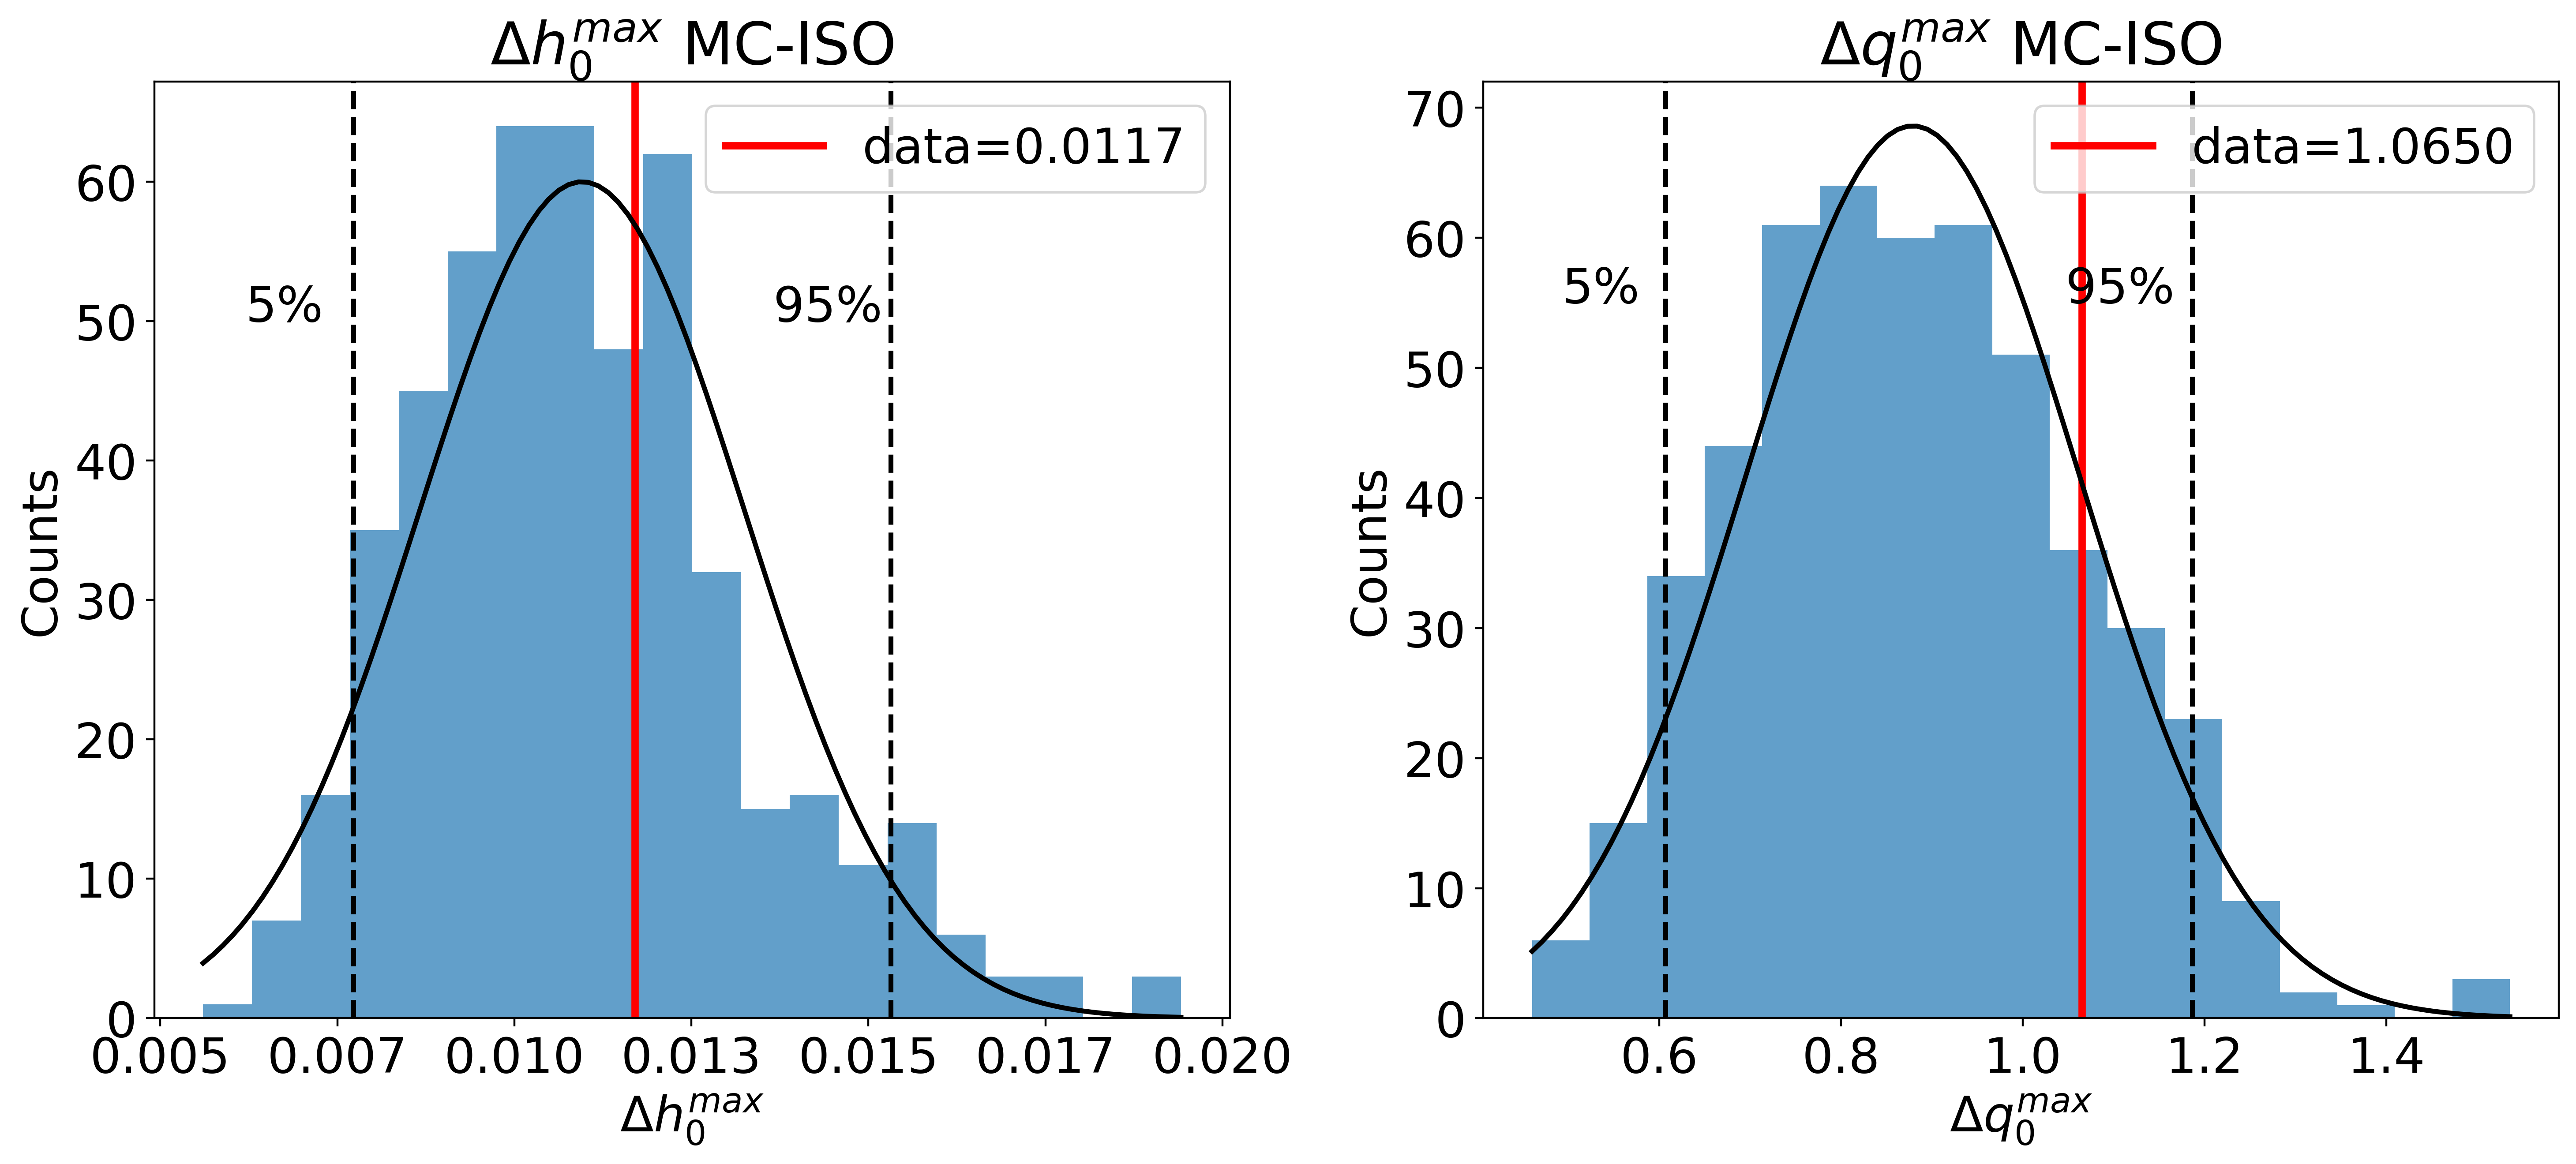

In [93]:
import matplotlib.ticker as ticker

def gaussian_log_likelihood(params, data):
    mean, std = params
    log_likelihood = np.sum(norm.logpdf(data, loc=mean, scale=std))
    return -log_likelihood


data_h0_iso = np.array(delta_h0_iso_max)
data_q0_iso = np.array(delta_q0_iso_max)

# Initial parameter guesses for the mean and standard deviation for both histograms
initial_guess_h0_iso = [np.mean(data_h0_iso), np.std(data_h0_iso)]
initial_guess_q0_iso = [np.mean(data_q0_iso), np.std(data_q0_iso)]

result_h0_iso = minimize(gaussian_log_likelihood, initial_guess_h0_iso, args=(
    data_h0_iso,), method='L-BFGS-B')
result_q0_iso = minimize(gaussian_log_likelihood, initial_guess_q0_iso, args=(
    data_q0_iso,), method='L-BFGS-B')

# Extract the optimized parameters for both histograms
mu_best_fit_h0_iso, std_best_fit_h0_iso = result_h0_iso.x
mu_best_fit_q0_iso, std_best_fit_q0_iso = result_q0_iso.x

# Generate the Gaussian curves for both nhistograms
x_gauss_h0_iso = np.linspace(np.min(data_h0_iso), np.max(data_h0_iso), 100)
y_gauss_h0_iso = norm.pdf(
    x_gauss_h0_iso, loc=mu_best_fit_h0_iso, scale=std_best_fit_h0_iso)

x_gauss_q0_iso = np.linspace(np.min(data_q0_iso), np.max(data_q0_iso), 100)
y_gauss_q0_iso = norm.pdf(
    x_gauss_q0_iso, loc=mu_best_fit_q0_iso, scale=std_best_fit_q0_iso)

percentile_5_h0_iso = np.percentile(data_h0_iso, 5)
percentile_95_h0_iso = np.percentile(data_h0_iso, 95)
percentile_5_q0_iso = np.percentile(data_q0_iso, 5)
percentile_95_q0_iso = np.percentile(data_q0_iso, 95)

# Create the histograms with subplots
hist4, ax4 = plt.subplots(1, 2, figsize=(15, 7))

# Histogram for delta_h0_iso_max
counts_h0_iso, bins_h0_iso, _ = ax4[0].hist(
    data_h0_iso, bins='auto', density=False, alpha=0.7)

bin_width_h0_iso = bins_h0_iso[1] - bins_h0_iso[0]

ax4[0].axvline(delta_h0_data_max, color='red', linestyle='solid',
               linewidth=3, label='data=%0.4f' % delta_h0_data_max)

ax4[0].axvline(percentile_5_h0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[0].axvline(percentile_95_h0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[0].text(percentile_5_h0_iso - 2.2*bin_width_h0_iso, 50, '5%', fontsize=20)

ax4[0].text(percentile_95_h0_iso-2.4*bin_width_h0_iso, 50, '95%', fontsize=20)

ax4[0].plot(x_gauss_h0_iso, y_gauss_h0_iso * len(data_h0_iso) * bin_width_h0_iso,
            'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax4[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax4[0].set_xlabel(r'$Δh_0^{max}$')
ax4[0].set_ylabel('Counts')
ax4[0].legend(loc='upper right')
ax4[0].set_title(r'$Δh_0^{max}$ MC-ISO')
# Histogram for delta_q0_iso_max
counts_q0_iso, bins_q0_iso, _ = ax4[1].hist(
    data_q0_iso, bins='auto', density=False, alpha=0.7)

bin_width_q0_iso = bins_q0_iso[1] - bins_q0_iso[0]

ax4[1].axvline(delta_q0_data_max, color='red', linestyle='solid',
               linewidth=3, label='data=%0.4f' % delta_q0_data_max)

ax4[1].axvline(percentile_5_q0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[1].axvline(percentile_95_q0_iso, color='black',
               linewidth=2, linestyle='dashed')

ax4[1].text(percentile_5_q0_iso - 1.8*bin_width_q0_iso, 55, '5%', fontsize=20)

ax4[1].text(percentile_95_q0_iso - 2.2 *
            bin_width_q0_iso, 55, '95%', fontsize=20)


ax4[1].plot(x_gauss_q0_iso, y_gauss_q0_iso * len(data_q0_iso) * bin_width_q0_iso,
            'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax4[1].set_xlabel(r'$Δq_0^{max}$')
ax4[1].set_ylabel('Counts')
ax4[1].legend(loc='upper right')
ax4[1].set_title(r'$Δq_0^{max}$ MC-ISO')
plt.tight_layout()
#plt.savefig(f'histograms/{prefix_name}[ISO](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png')
plt.show()

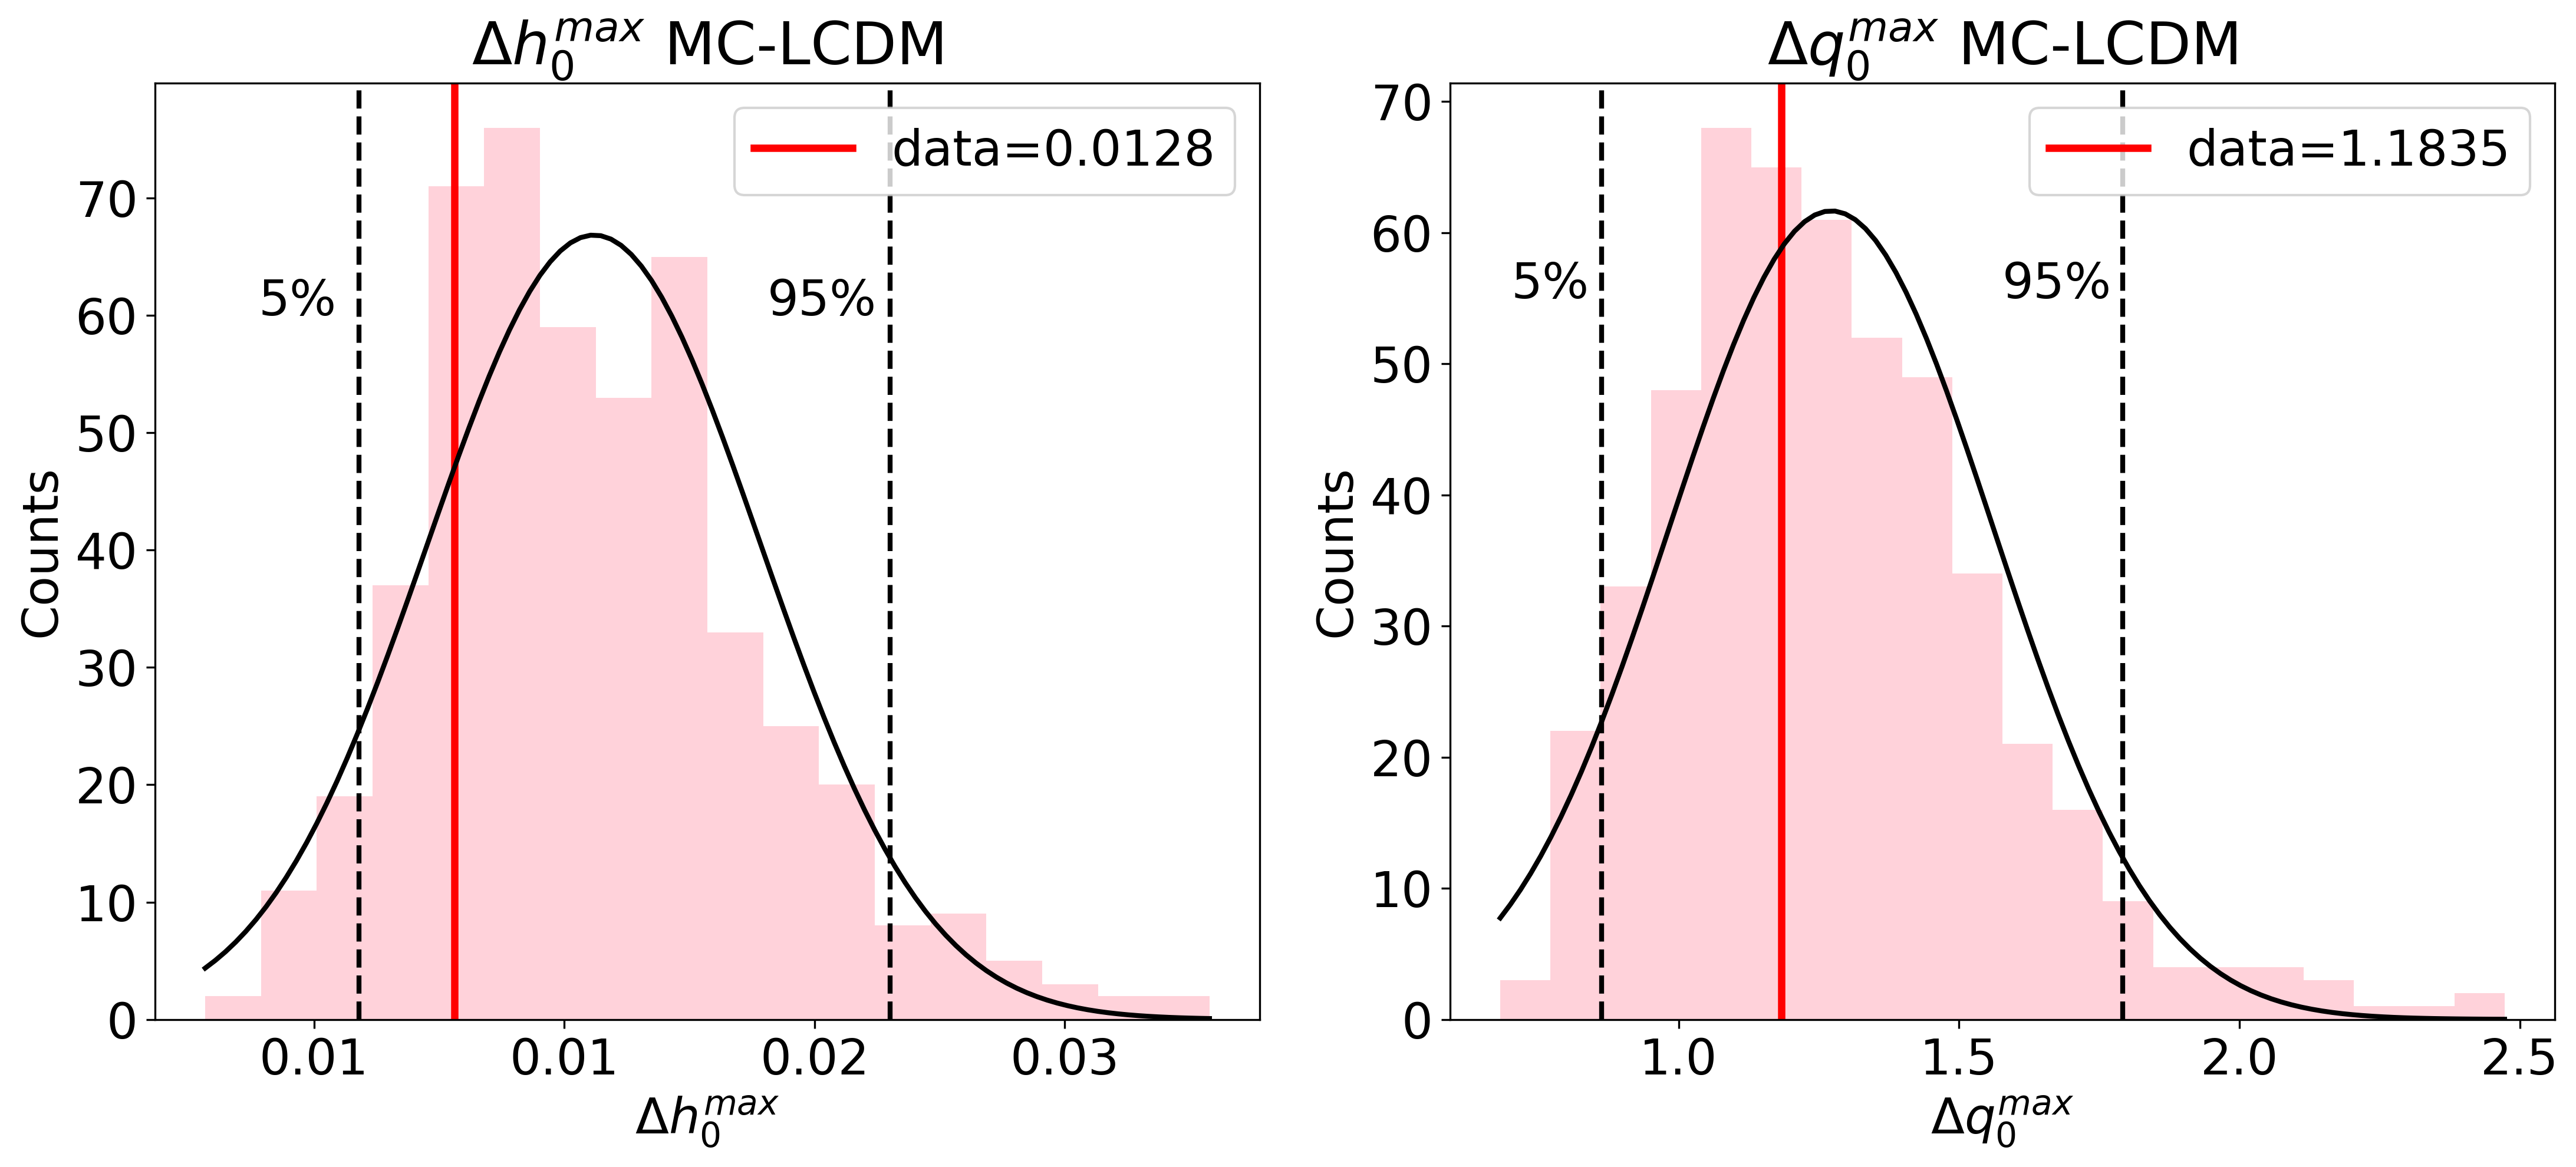

In [238]:
import matplotlib.ticker as ticker
delta_h0_lcdm_max = np.array(delta_h0_lcdm_max)
data_q0_lcdm = np.array(delta_q0_lcdm_max)

# Initial parameter guesses for the mean and standard deviation for both histograms
initial_guess_h0_lcdm = [np.mean(delta_h0_lcdm_max), np.std(delta_h0_lcdm_max)]
initial_guess_q0_lcdm = [np.mean(data_q0_lcdm), np.std(data_q0_lcdm)]

result_h0_lcdm = minimize(gaussian_log_likelihood, initial_guess_h0_lcdm, args=(delta_h0_lcdm_max,), method='L-BFGS-B')
result_q0_lcdm = minimize(gaussian_log_likelihood, initial_guess_q0_lcdm, args=(data_q0_lcdm,), method='L-BFGS-B')

# Extract the optimized parameters for both histograms
mu_best_fit_h0_lcdm, std_best_fit_h0_lcdm = result_h0_lcdm.x
mu_best_fit_q0_lcdm, std_best_fit_q0_lcdm = result_q0_lcdm.x

# Generate the Gaussian curves for both nhistograms
x_gauss_h0_lcdm = np.linspace(np.min(delta_h0_lcdm_max), np.max(delta_h0_lcdm_max), 100)
y_gauss_h0_lcdm = norm.pdf(x_gauss_h0_lcdm, loc=mu_best_fit_h0_lcdm, scale=std_best_fit_h0_lcdm)

x_q0_lcdm = np.linspace(np.min(data_q0_lcdm), np.max(data_q0_lcdm), 100)
y_gaussian_q0_lcdm = norm.pdf(x_q0_lcdm, loc=mu_best_fit_q0_lcdm, scale=std_best_fit_q0_lcdm)

percentile_5_h0_lcdm = np.percentile(delta_h0_lcdm_max, 5)
percentile_95_h0_lcdm = np.percentile(delta_h0_lcdm_max, 95)
percentile_5_q0_lcdm = np.percentile(data_q0_lcdm, 5)
percentile_95_q0_lcdm = np.percentile(data_q0_lcdm, 95)


# Create the histograms with subplots
hist3, ax3 = plt.subplots(1, 2, figsize=(15, 7))

# Histogram for delta_h0_lcdm_lcdm_max
counts_h0_lcdm, bins_h0_lcdm, _ = ax3[0].hist(delta_h0_lcdm_max, bins='auto', color='pink', density=False, alpha=0.7)

bin_width_h0_lcdm = bins_h0_lcdm[1] - bins_h0_lcdm[0]

ax3[0].axvline(delta_h0_data_max, color='red', linestyle='solid', linewidth=3, label='data=%0.4f' % delta_h0_data_max)

ax3[0].plot(x_gauss_h0_lcdm, y_gauss_h0_lcdm * len(delta_h0_lcdm_max) * bin_width_h0_lcdm, 'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax3[0].axvline(percentile_5_h0_lcdm, color='black', linewidth=2, linestyle='dashed')
ax3[0].axvline(percentile_95_h0_lcdm, color='black', linewidth=2, linestyle='dashed')

ax3[0].text(percentile_5_h0_lcdm-1.8*bin_width_h0_lcdm, 60, '5%', fontsize=20)
ax3[0].text(percentile_95_h0_lcdm-2.2*bin_width_h0_lcdm, 60, '95%', fontsize=20)

ax3[0].set_xlabel(r'$\Delta h_0^{max}$')
ax3[0].set_ylabel('Counts')
ax3[0].legend(loc='upper right')
ax3[0].set_title(r'$\Delta h_0^{max}$ MC-LCDM')

# Limit the number of decimals on the x-axis labels to 3
ax3[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Histogram for delta_q0_lcdm_lcdm_max
counts_q0_lcdm, bins_q0_lcdm, _ = ax3[1].hist(data_q0_lcdm, bins='auto', color='pink', density=False, alpha=0.7)

bin_width_q0_lcdm = bins_q0_lcdm[1] - bins_q0_lcdm[0]

ax3[1].axvline(delta_q0_data_max, color='red', linestyle='solid', linewidth=3, label='data=%0.4f' % delta_q0_data_max)

ax3[1].plot(x_q0_lcdm, y_gaussian_q0_lcdm * len(data_q0_lcdm) * bin_width_q0_lcdm, 'black', linewidth=2)  # Scale Gaussian fit to match total counts

ax3[1].axvline(percentile_5_q0_lcdm, color='black', linewidth=2, linestyle='dashed')
ax3[1].axvline(percentile_95_q0_lcdm, color='black', linewidth=2, linestyle='dashed')

ax3[1].text(percentile_5_q0_lcdm-1.8*bin_width_q0_lcdm, 55, '5%', fontsize=20)
ax3[1].text(percentile_95_q0_lcdm-2.4*bin_width_q0_lcdm, 55, '95%', fontsize=20)

ax3[1].set_xlabel(r'$\Delta q_0^{max}$')
ax3[1].set_ylabel('Counts')
ax3[1].legend(loc='upper right')
ax3[1].set_title(r'$\Delta q_0^{max}$ MC-LCDM')

plt.tight_layout()
plt.savefig(f'histograms/{prefix_name}[LCDM](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png')
plt.show()

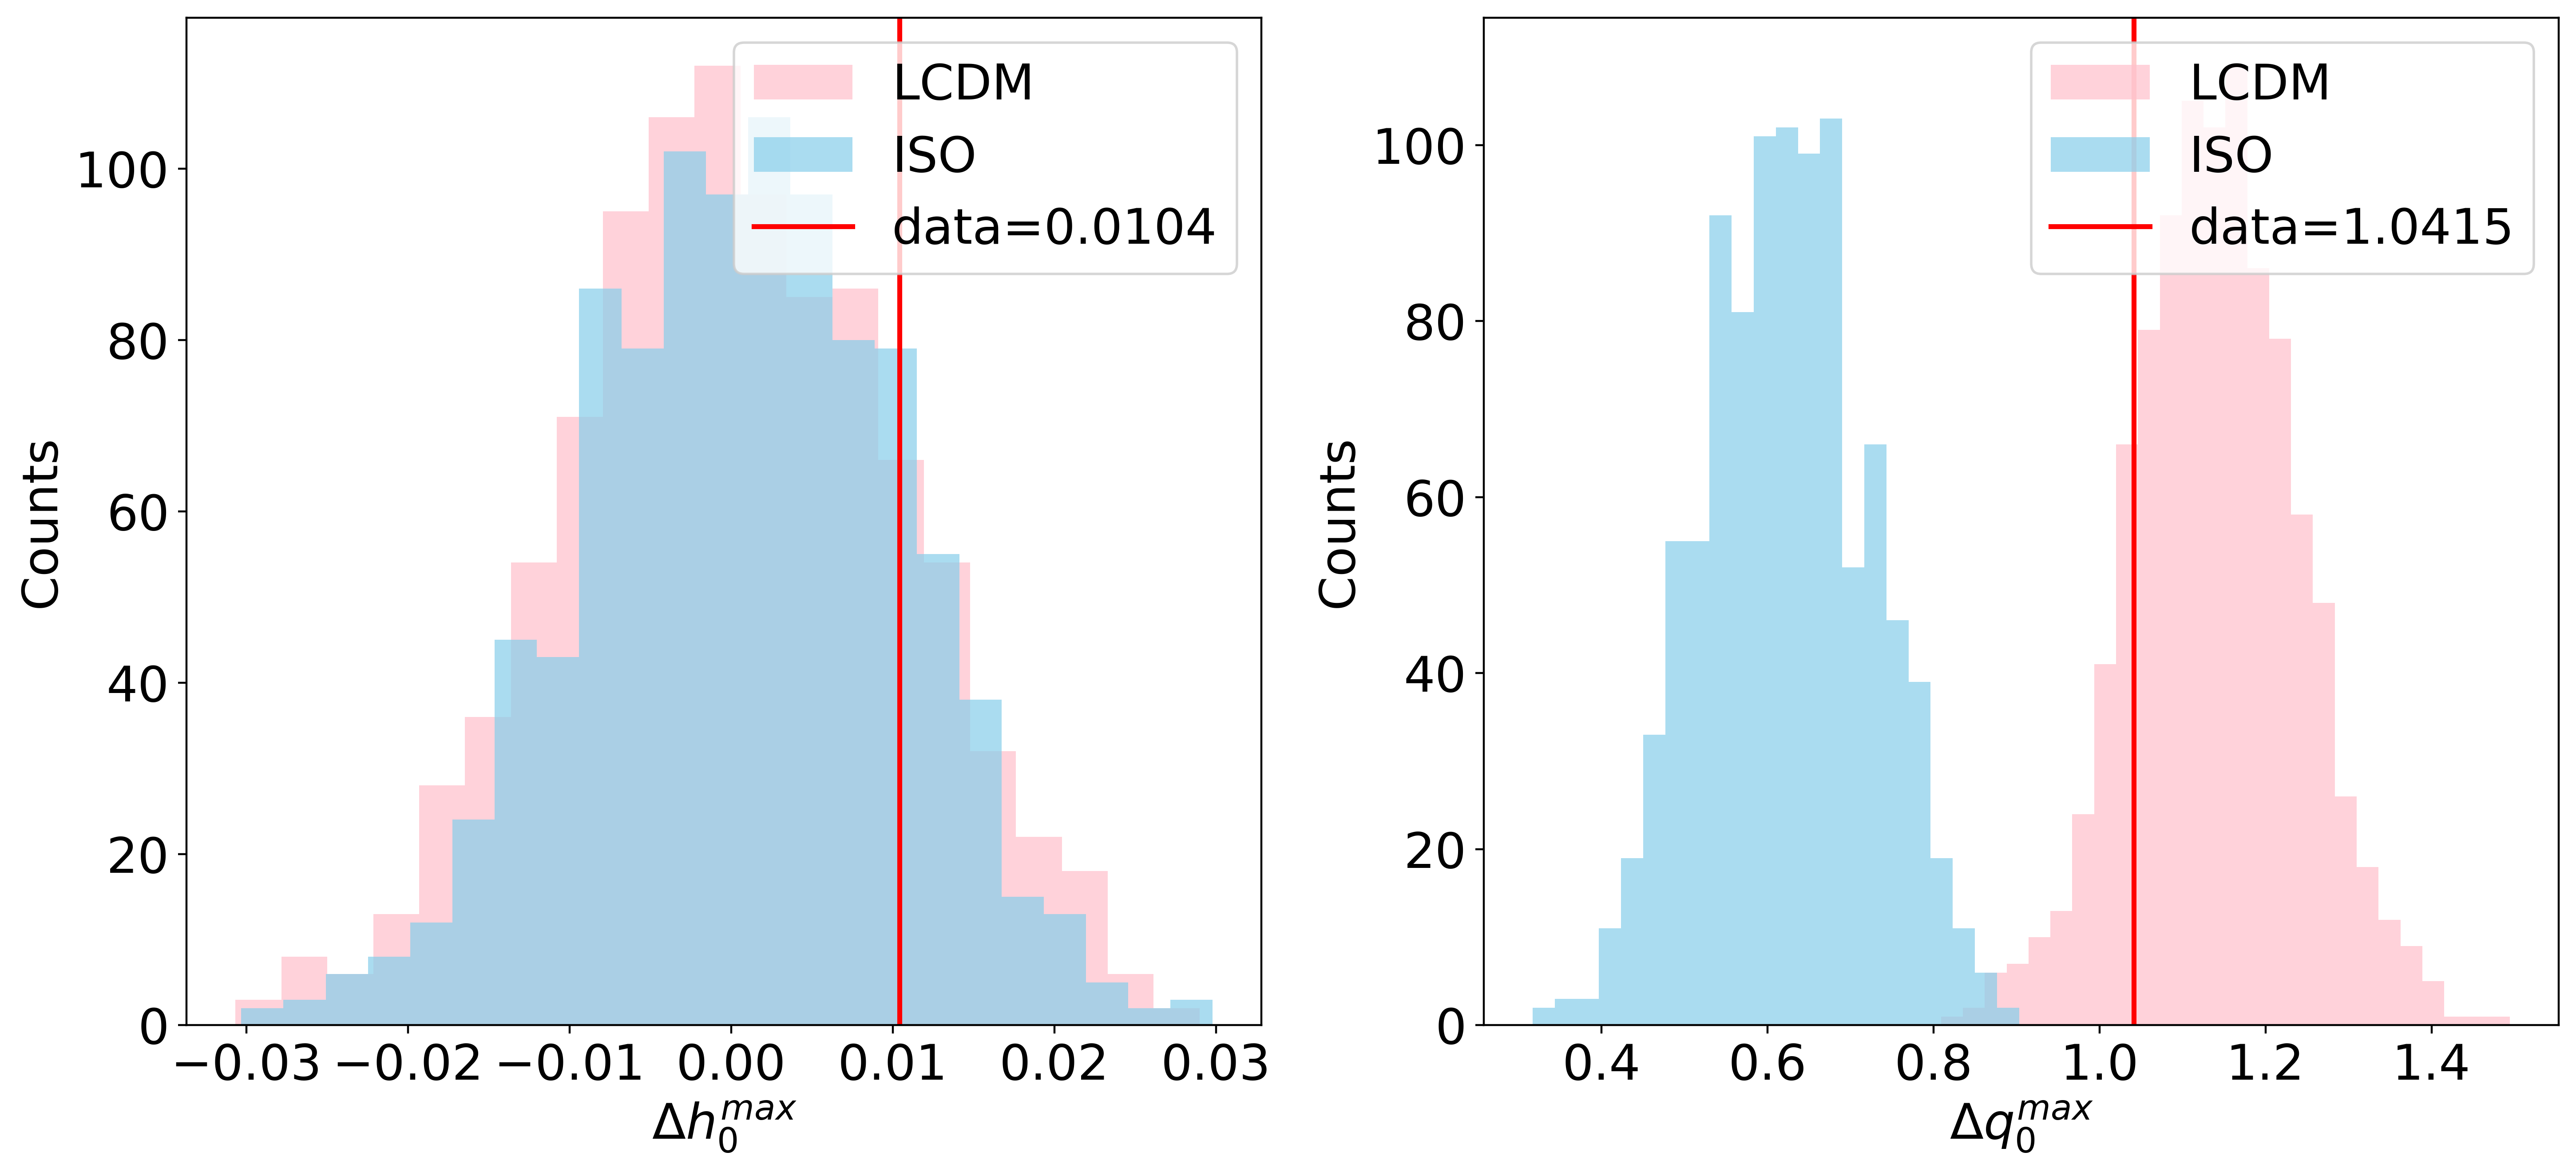

In [327]:
rcParams['font.size']= 20
delta_h0_lcdm_max = np.array(delta_h0_lcdm_max)
data_q0_lcdm = np.array(delta_q0_lcdm_max)
data_h0_iso = np.array(delta_h0_iso_max)
data_q0_iso = np.array(delta_q0_iso_max)

# Create the histograms with subplots
hist2, ax2 = plt.subplots(1, 2, figsize=(15, 7))
# Histogram for delta_h0 with different colors for LCDM and ISO
ax2[0].hist(delta_h0_lcdm_max, color='pink', bins='auto', alpha=0.7, label='LCDM')
ax2[0].hist(data_h0_iso, color='skyblue', bins='auto', alpha=0.7, label='ISO')
ax2[0].axvline(delta_h0_data_max, color='red', linestyle='solid', linewidth=2, label='data=%0.4f' % delta_h0_data_max)
ax2[0].legend(loc='upper right')  # Adjust the legend to the upper right
ax2[0].set_xlabel(r'$Δh_0^{max}$')
ax2[0].set_ylabel('Counts')

# Histogram for delta_q0 with different colors for LCDM and ISO
ax2[1].hist(data_q0_lcdm, color='pink', bins='auto', alpha=0.7, label='LCDM')
ax2[1].hist(data_q0_iso, color='skyblue', bins='auto', alpha=0.7, label='ISO')
ax2[1].axvline(delta_q0_data_max, color='red', linestyle='solid', linewidth=2, label='data=%0.4f' % delta_q0_data_max)  # plot the data value
ax2[1].legend(loc='upper right')  # Adjust the legend to the upper right
ax2[1].set_xlabel(r'$Δq_0^{max}$')
ax2[1].set_ylabel('Counts')

# Set the title and adjust the layout
#hist2.suptitle(rf'{prefix_name} $Δh_{{\mathrm{{max}}}}$ and $Δq_{{\mathrm{{max}}}}$ histograms for LCDM and ISO distributions')
plt.tight_layout()

#plt.savefig(f'histograms/{prefix_name}[BOTH](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png')
plt.show()

# Some statistics

In [338]:
import get_statistics
reload(get_statistics)

get_statistics.mc_statistics(delta_h0_lcdm_max, delta_h0_iso_max, delta_q0_lcdm_max, delta_q0_iso_max, delta_h0_data_max, delta_q0_data_max)

Porcentaje de repeticiones que dan delta_h0 mayor a los datos (ISO) = 16.6
Porcentaje de repeticiones que dan delta_q0 mayor a los datos (ISO) = 0.0

Porcentaje de repeticiones que dan delta_h0 mayor a los datos (LCDM) = 100.0
Porcentaje de repeticiones que dan delta_q0 mayor a los datos (LCDM) = 0.0

La media de delta_h0_max (ISO) es = 2.6190939972167954e-05
La media de delta_q0_max (ISO) es = 0.0006849586740948753

La media de delta_h0_max (LCDM) es = 1.1402863167312178
La media de delta_q0_max (LCDM) es = 0.6221070327725319

La desviación estándar de delta_h0_max (ISO) es = 0.010369314352314755
La desviación estándar de delta_q0_max (ISO) es = 0.009642585078219872

La desviación estándar de delta_h0_max (LCDM) es = 0.10065317329719409
La desviación estándar de delta_q0_max (LCDM) es = 0.09948570204857293


In [241]:
#create a table that contains the "pvalues" for each parameter 

pvalues = np.array([p_h0_iso_max, p_q0_iso_max, p_h0_lcdm_max, p_q0_lcdm_max])

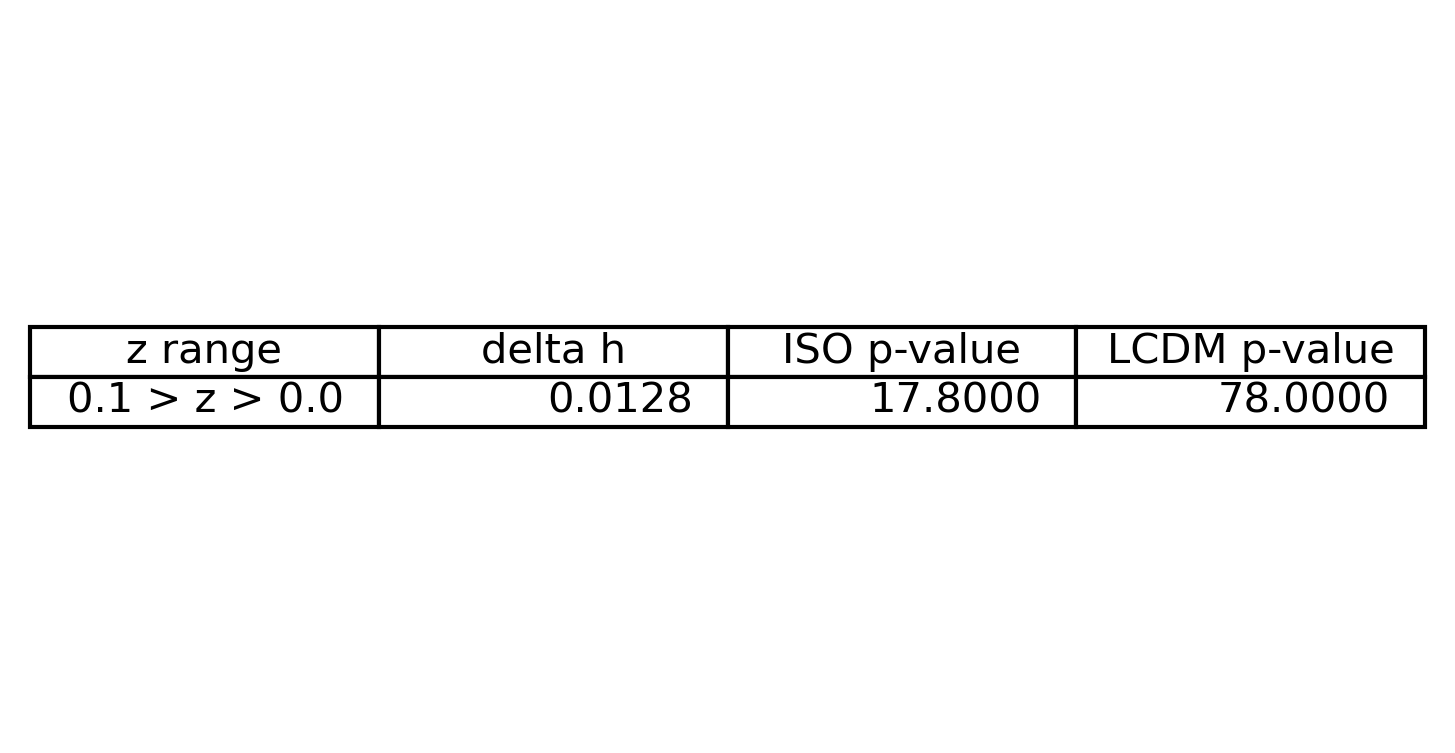

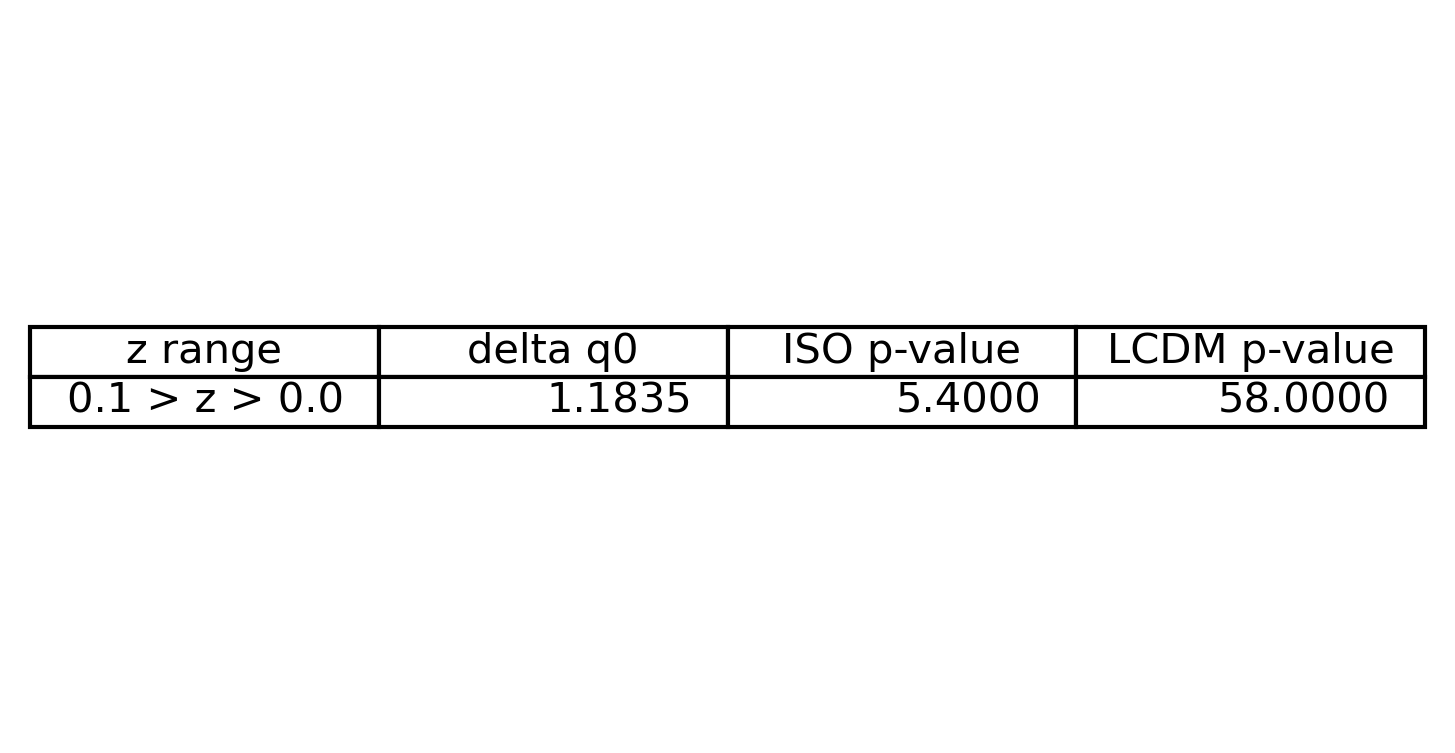

In [243]:
rcParams['figure.dpi'] = 300
z_ranges = [f"{zup} > z > {zdown}"]

delta_h = [f"{delta_h0_data_max:.4f}"]
iso_pvalues = [f"{p_h0_iso_max:.4f}"]
lcdm_pvalues = [f"{p_h0_lcdm_max:.4f}"]

delta_q0 = [f"{delta_q0_data_max:.4f}"]
iso_q0_pvalues = [f"{p_q0_iso_max:.4f}"]
lcdm_q0_pvalues = [f"{p_q0_lcdm_max:.4f}"]

# Crear el DataFrame para el mapa de Hubble
df_hubble = pd.DataFrame({"z range": z_ranges, "delta h": delta_h, "ISO p-value": iso_pvalues, "LCDM p-value": lcdm_pvalues})

# Crear el DataFrame para los valores de q0
df_q0 = pd.DataFrame({"z range": z_ranges, "delta q0": delta_q0, "ISO p-value": iso_q0_pvalues, "LCDM p-value": lcdm_q0_pvalues})

# Crear la figura y el eje para la tabla del mapa de Hubble
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_hubble.values, colLabels=df_hubble.columns, loc='center')

# Guardar la tabla del mapa de Hubble en un archivo PNG
plt.savefig(f'tables/{prefix_name}[h0_table](hf={h0f}_qf={q0f})_({zup}>z>{zdown})({pts}_pts)_({len(delta_h0_iso_max)})_rep_.png')

# Crear la figura y el eje para la tabla de q0
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_q0.values, colLabels=df_q0.columns, loc='center')

# Guardar la tabla de q0 en un archivo PNG
plt.savefig(f'tables/{prefix_name}[q0_table](hf={h0f}_qf={q0f})_({zup}>z>{zdown})({pts}_pts)_({len(delta_h0_iso_max)})_rep_.png')